In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
import itertools as it

from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import pandas as pd

class data_object(object):
    def __init__(self, name):
        self.name = name

In [2]:
plt.style.use('seaborn-poster')

In [3]:
with open('random_states_1.pickle','rb') as f:
    random_states = pickle.load(f)
random_states = {i:random_states[i] for i in random_states if i <= 400}

# First, let's take a look at solution statistics

In [4]:
total_runs = []
finished_initialization = []
finished_DDF = []
finished_optimization = []

with open('./log/master/master_log_1_400.txt','r') as f:
    for key, group in it.groupby(f,lambda line: line.startswith('------------')):
        if not key:
            run_data = list(group)
            
            # get run number
            start = 'Preset_Case:_'
            end = '_'
            s = run_data[2]
            run_case = int(s[s.find(start)+len(start):s.rfind(end)])
            total_runs.append(run_case)
            
            # get status
            if 'Success: > Initialization\n' in run_data:
                finished_initialization.append(True)
            else:
                finished_initialization.append(False)
            if 'Success: > Added DDF formulation\n' in run_data:
                finished_DDF.append(True)
            else:
                finished_DDF.append(False)
            if 'Success: > One-step Optimization\n' in run_data:
                finished_optimization.append(True)
            else:
                finished_optimization.append(False)
                
finished_initialization = np.array(finished_initialization)
finished_DDF = np.array(finished_DDF)
finished_optimization = np.array(finished_optimization)

In [5]:
reactive_stages = random_states[1].temperature_flag.keys()

In [6]:
def divide_data(x):
    x = np.array(x)
    return x, x[finished_initialization], x[finished_optimization]

## Total number of attempts

In [7]:
len(total_runs)

400

## Successfully initialized

In [8]:
sum(finished_initialization)

290

## Successfully adopted DDF formulation

In [9]:
sum(finished_DDF)

288

## Successfully reached optimum solution

In [10]:
sum(finished_optimization)

199

# Different starting points doesn't seem to drastically affect success rate

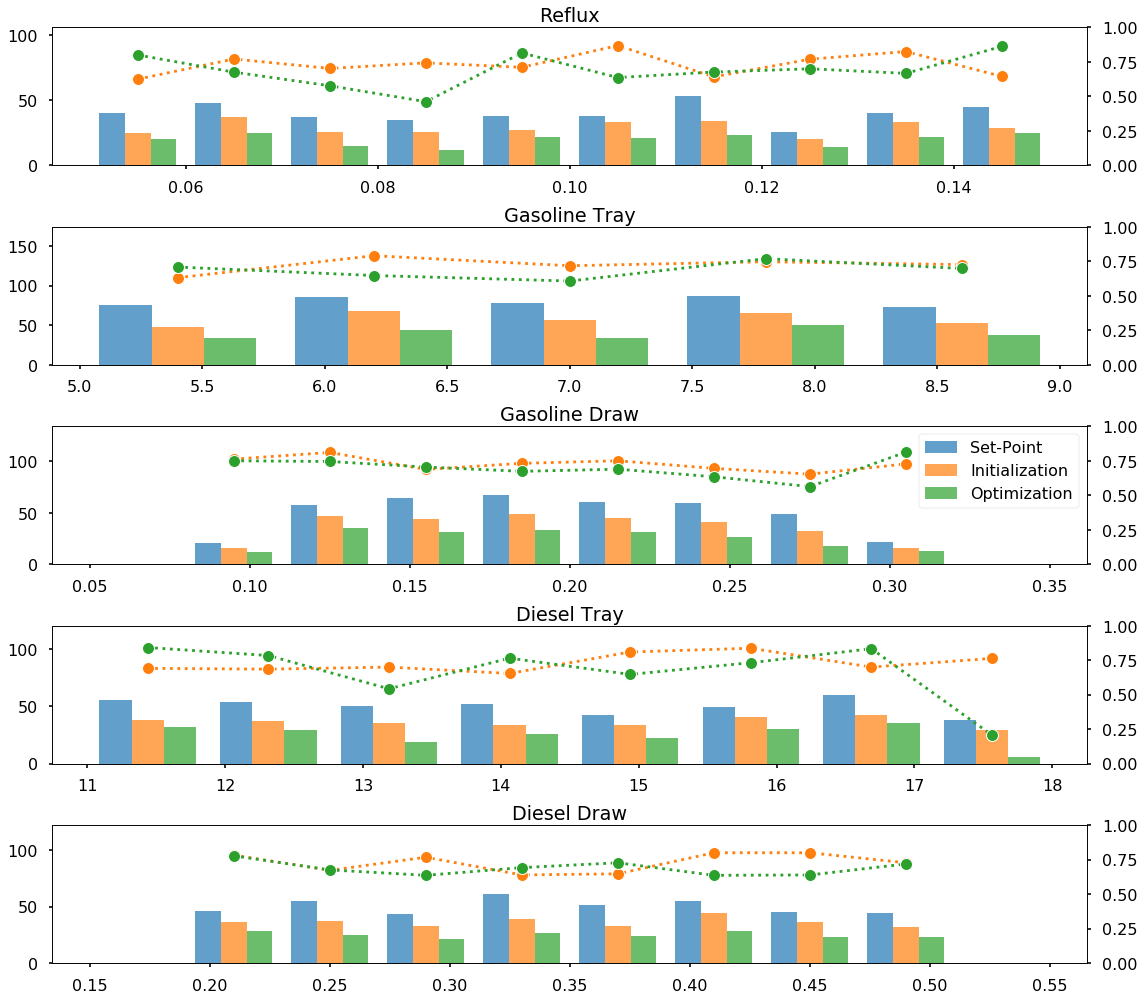

In [11]:
reflux_ratio_all = np.array([random_states[i].rr_ratio for i in random_states if i in total_runs])
gasoline_location_all = np.array([sorted(random_states[i].side_draw_flag.keys())[1] for i in random_states if i in total_runs])
gasoline_draw_all = np.array([list(random_states[i].side_draw_flag.values())[1] for i in random_states if i in total_runs])
diesel_location_all = np.array([sorted(random_states[i].side_draw_flag.keys())[2] for i in random_states if i in total_runs])
diesel_draw_all = np.array([list(random_states[i].side_draw_flag.values())[2] for i in random_states if i in total_runs])

fig, axs = plt.subplots(5,1,figsize=(16,14))

tmp_dic = {0:(reflux_ratio_all,'Reflux',(0.05,0.15),10),
          1:(gasoline_location_all,'Gasoline Tray',(5,9),5),
          2:(gasoline_draw_all,'Gasoline Draw',(0.05,0.35),10),
          3:(diesel_location_all,'Diesel Tray',(11,18),8),
          4:(diesel_draw_all,'Diesel Draw',(0.15,0.55),10)}

for j in range(5):
    y, bins, patches = axs[j].hist((divide_data(tmp_dic[j][0])),bins=tmp_dic[j][3],histtype='bar',range=tmp_dic[j][2],alpha=0.7)
    ymax = max(y[0])
    axs[j].set_ylim(bottom=0,top=2*ymax)

    bincenters = 0.5*(bins[1:]+bins[:-1])
    ratio_init = [float('nan') if j==0 or i==0 else i/j for i,j in zip(y[1],y[0])]
    ratio_opt = [float('nan') if j==0 or i==0 else i/j for i,j in zip(y[2],y[1])]

    ax_ = plt.twinx(axs[j])
    ax_.plot(bincenters,ratio_init,'C1:o',markeredgecolor='w',markersize=12,markeredgewidth = 1)
    ax_.plot(bincenters,ratio_opt,'C2:o',markeredgecolor='w',markersize=12,markeredgewidth = 1)
    ax_.set_ylim(0,1)

    # ax.grid()
    axs[j].set_title(tmp_dic[j][1])

axs[2].legend(['Set-Point','Initialization','Optimization'])
plt.tight_layout()
plt.show()
plt.close()

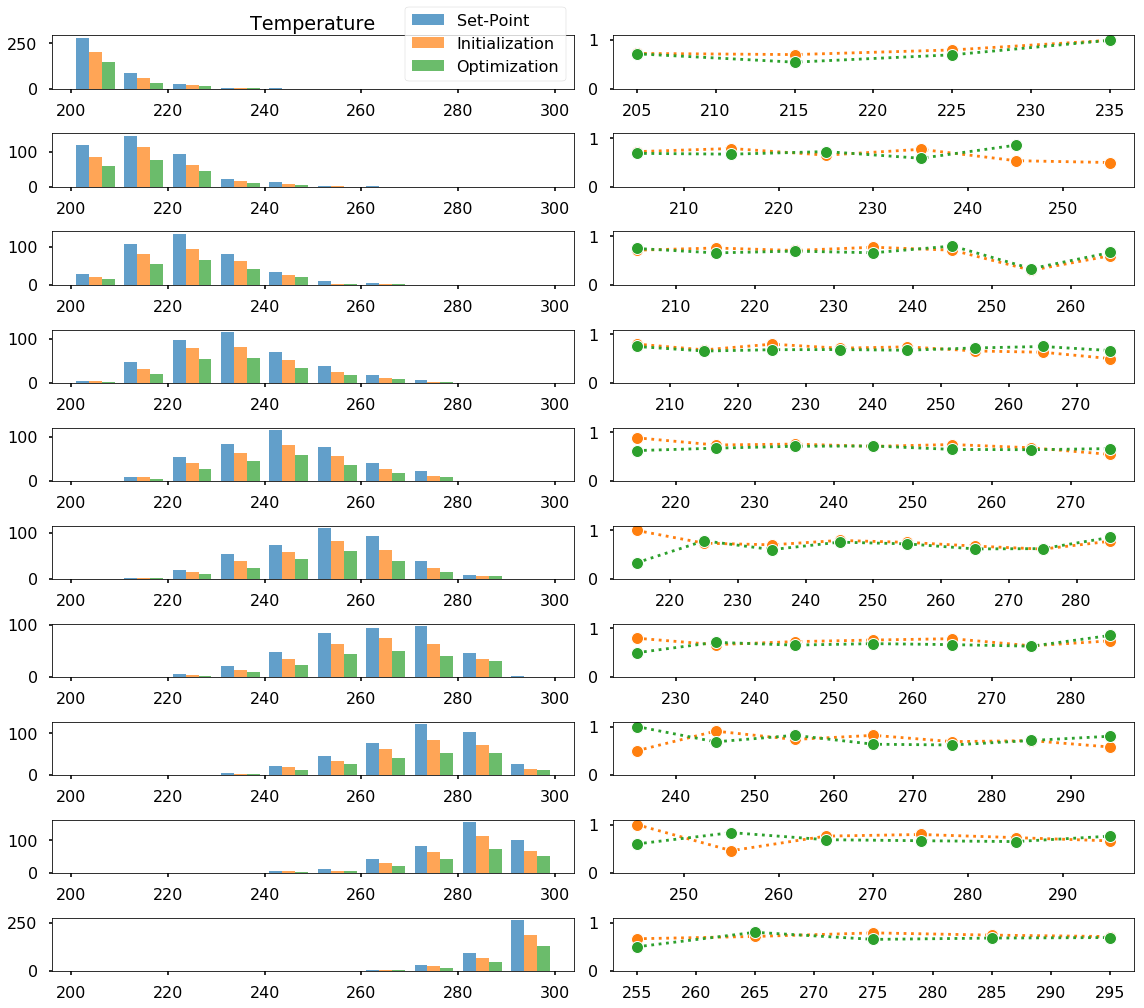

In [12]:
temperature_all = {j:np.array([random_states[i].temperature_flag[j] for i in random_states if i in total_runs])\
                   for j in reactive_stages}

fig, axs = plt.subplots(len(reactive_stages),2,figsize=(16,14))

for j_, j in enumerate(reactive_stages):
    y, bins, patches = axs[j_][0].hist(divide_data(temperature_all[j]),bins=10,histtype='bar',range=(200,300),alpha=0.7)
    ymax = max(y[0])
    # ax.set_ylim(bottom=0,top=2*ymax)

    bincenters = 0.5*(bins[1:]+bins[:-1])
    ratio_init = [float('nan') if j==0 or i==0 else i/j for i,j in zip(y[1],y[0])]
    ratio_opt = [float('nan') if j==0 or i==0 else i/j for i,j in zip(y[2],y[1])]

    axs[j_][1].plot(bincenters,ratio_init,'C1:o',markeredgecolor='w',markersize=12,markeredgewidth = 1)
    axs[j_][1].plot(bincenters,ratio_opt,'C2:o',markeredgecolor='w',markersize=12,markeredgewidth = 1)
    axs[j_][1].set_ylim(0,1.1)

axs[0][0].set_title('Temperature')
axs[0][0].legend(['Set-Point','Initialization','Optimization'])

plt.tight_layout()
plt.show()
plt.close()

# Strong 1-sided start seems to increase success rate

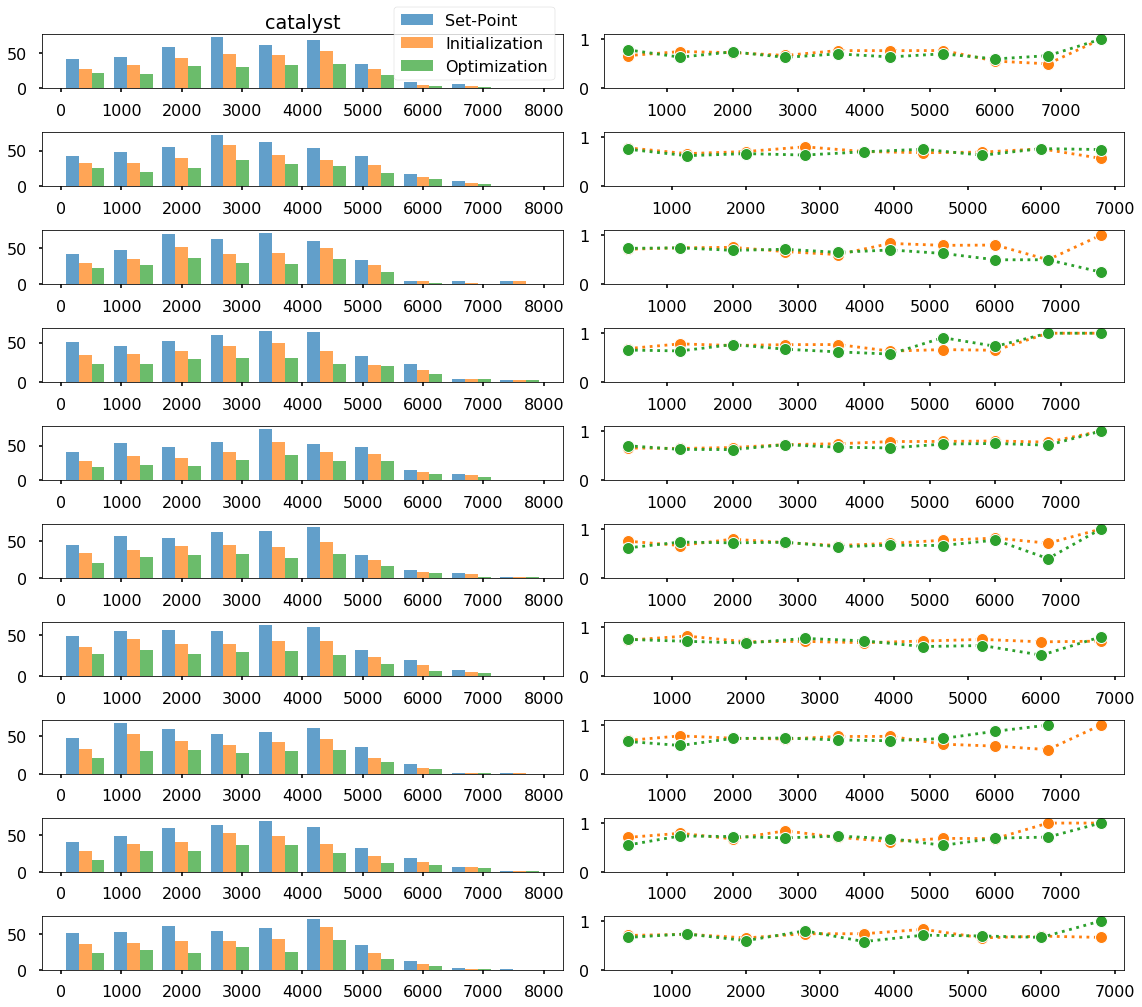

In [13]:
catalyst_all = {j:np.array([random_states[i].catalyst_flag[j] for i in random_states if i in total_runs])\
                   for j in reactive_stages}

fig, axs = plt.subplots(len(reactive_stages),2,figsize=(16,14))

for j_, j in enumerate(reactive_stages):
    y, bins, patches = axs[j_][0].hist(divide_data(catalyst_all[j]),bins=10,histtype='bar',range=(0,8000),alpha=0.7)
    ymax = max(y[0])
    # ax.set_ylim(bottom=0,top=2*ymax)

    bincenters = 0.5*(bins[1:]+bins[:-1])
    ratio_init = [float('nan') if j==0 or i==0 else i/j for i,j in zip(y[1],y[0])]
    ratio_opt = [float('nan') if j==0 or i==0 else i/j for i,j in zip(y[2],y[1])]

    axs[j_][1].plot(bincenters,ratio_init,'C1:o',markeredgecolor='w',markersize=12,markeredgewidth = 1)
    axs[j_][1].plot(bincenters,ratio_opt,'C2:o',markeredgecolor='w',markersize=12,markeredgewidth = 1)
    axs[j_][1].set_ylim(0,1.1)

axs[0][0].set_title('catalyst')
axs[0][0].legend(['Set-Point','Initialization','Optimization'])

plt.tight_layout()
plt.show()
plt.close()

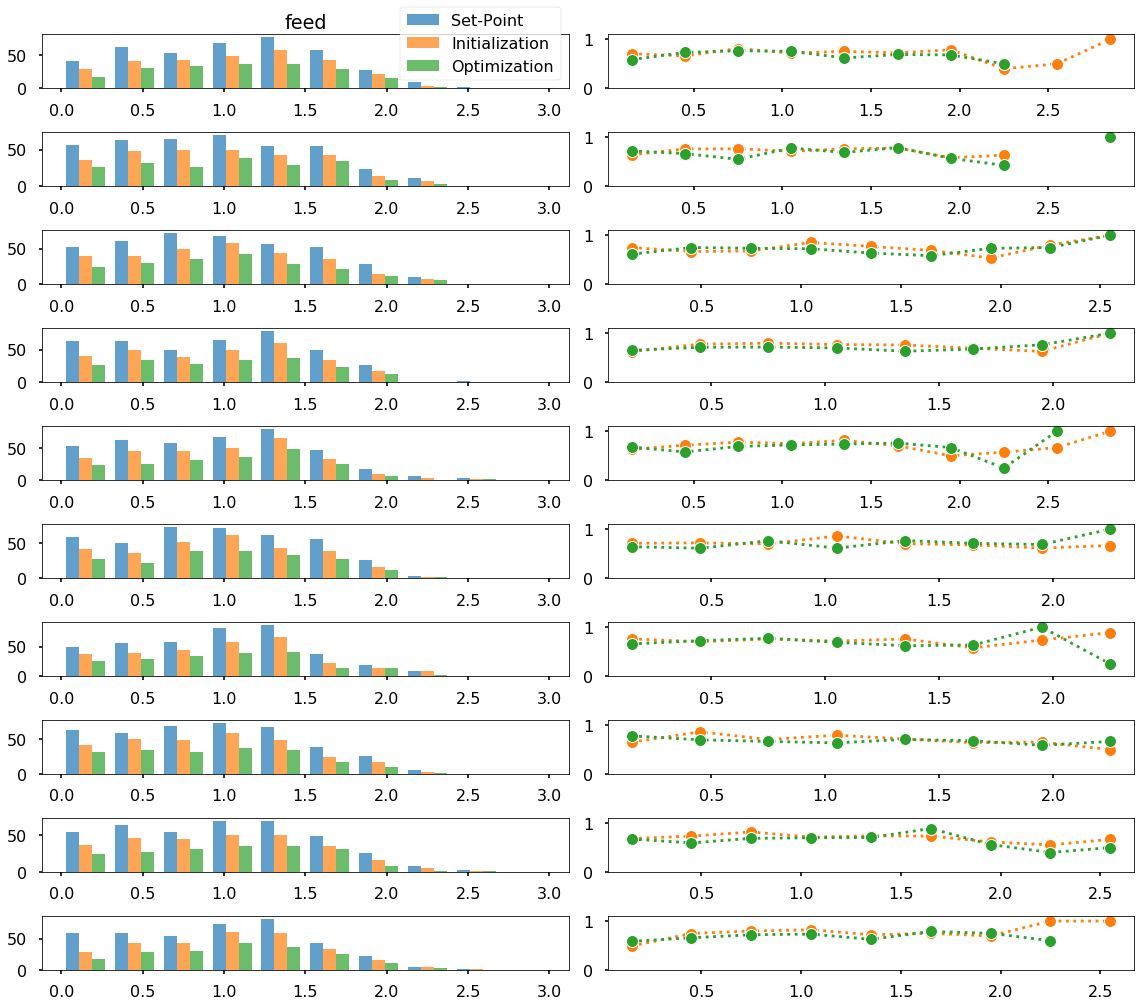

In [14]:
feed_all = {j:np.array([random_states[i].feed_flag[j] for i in random_states if i in total_runs])\
                   for j in reactive_stages}

fig, axs = plt.subplots(len(reactive_stages),2,figsize=(16,14))

for j_, j in enumerate(reactive_stages):
    y, bins, patches = axs[j_][0].hist(divide_data(feed_all[j]),bins=10,histtype='bar',range=(0,3),alpha=0.7)
    ymax = max(y[0])
    # ax.set_ylim(bottom=0,top=2*ymax)

    bincenters = 0.5*(bins[1:]+bins[:-1])
    ratio_init = [float('nan') if j==0 or i==0 else i/j for i,j in zip(y[1],y[0])]
    ratio_opt = [float('nan') if j==0 or i==0 else i/j for i,j in zip(y[2],y[1])]

    axs[j_][1].plot(bincenters,ratio_init,'C1:o',markeredgecolor='w',markersize=12,markeredgewidth = 1)
    axs[j_][1].plot(bincenters,ratio_opt,'C2:o',markeredgecolor='w',markersize=12,markeredgewidth = 1)
    axs[j_][1].set_ylim(0,1.1)

axs[0][0].set_title('feed')
axs[0][0].legend(['Set-Point','Initialization','Optimization'])

plt.tight_layout()
plt.show()
plt.close()

# Reduce dimension for visulization using PCA, uniform distribution, expect to yield little capture

In [15]:
x_data = np.stack((reflux_ratio_all,gasoline_location_all,gasoline_draw_all,diesel_location_all,diesel_draw_all,\
        *[temperature_all[j] for j in temperature_all],*[catalyst_all[j] for j in temperature_all],\
         *[feed_all[j] for j in temperature_all]),axis=1)

## 35 features with 400 observations

In [16]:
x_data.shape

(400, 35)

In [17]:
center_scaled = StandardScaler().fit_transform(x_data)
pca = PCA(n_components=10)
scores = pca.fit_transform(center_scaled)

### Eigenvalues

In [18]:
pca.explained_variance_

array([5.4159941 , 1.99772815, 1.61906218, 1.57272772, 1.47221417,
       1.40624853, 1.36944783, 1.34097983, 1.30445563, 1.22896188])

### Captured Covariance

In [19]:
pca.explained_variance_ratio_

array([0.15435583, 0.05693525, 0.04614327, 0.04482274, 0.0419581 ,
       0.04007808, 0.03902926, 0.03821793, 0.03717699, 0.03502541])

### Loadings - PC1 - Mostly independent, except temperature, which have same signs, meaning one temperature increases, the other ones increases, this response is modelled by sorting temperature from low to high

In [20]:
len(pca.components_[0])

35

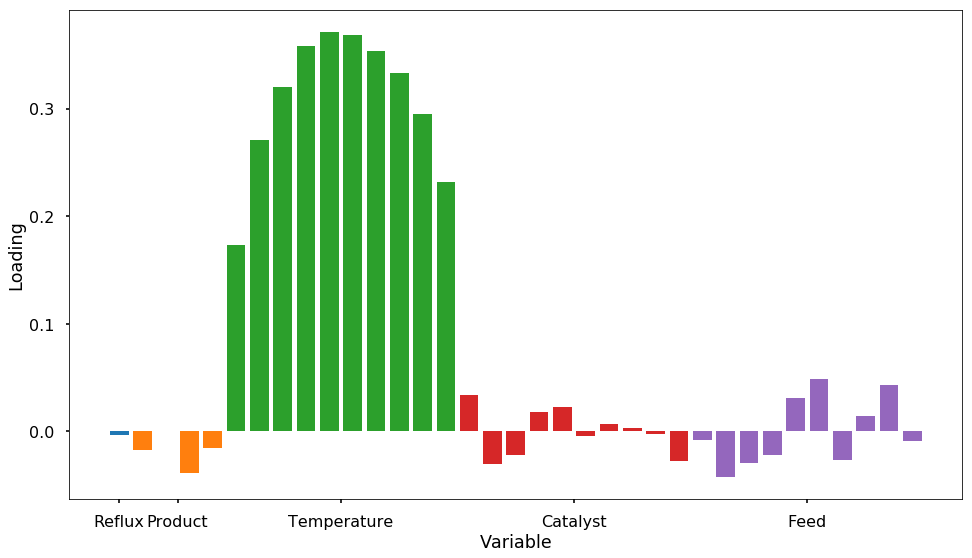

In [21]:
fig, axs = plt.subplots(figsize=(16,9))
x_loc = np.arange(1,len(pca.components_[0])+1)
grouping = {'Reflux':slice(0,1),'Product':slice(1,5),'Temperature':slice(5,15),\
            'Catalyst':slice(15,25),'Feed':slice(25,None)}

for key in grouping:
    axs.bar(x_loc[grouping[key]],pca.components_[0][grouping[key]])
axs.set_xticks([1,3.5,10.5,20.5,30.5])
axs.set_xticklabels(list(grouping.keys()))

axs.set_xlabel('Variable')
axs.set_ylabel('Loading')
plt.show()
plt.close()

### Scores - Success rate is not biased towards certain combination, uniform distributed set of initialized solutions for optimization multi-start

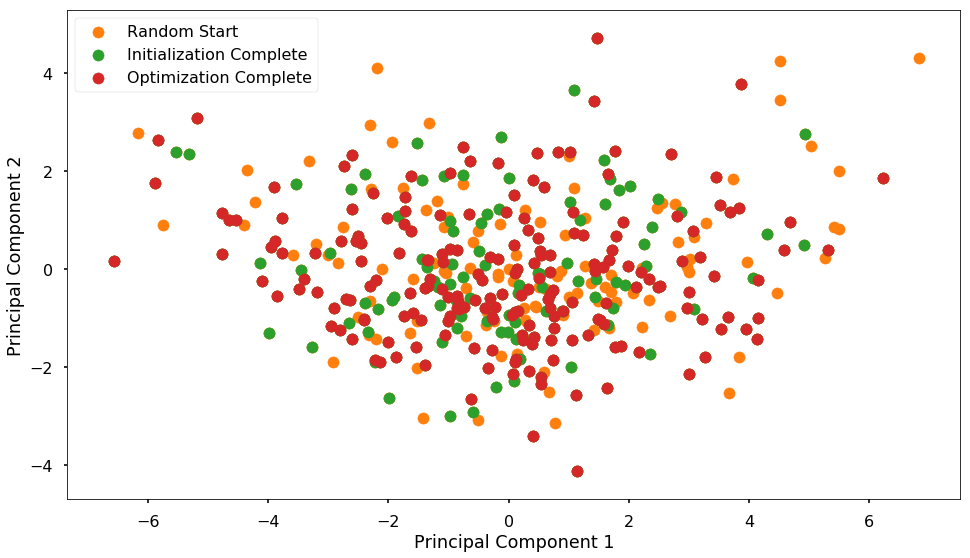

In [22]:
fig, axs = plt.subplots(figsize=(16,9))

targets = ['Random Start', 'Initialization Complete', 'Optimization Complete']
colors = ['C1', 'C2', 'C3']
masks = {'Random Start':True,\
         'Initialization Complete':finished_initialization,\
         'Optimization Complete':finished_optimization}

for target, color in zip(targets,colors):
    mask = masks[target]
    axs.scatter(scores[:,0][mask],scores[:,1][mask],color=color,label=target)

axs.legend()
axs.set_xlabel('Principal Component 1')
axs.set_ylabel('Principal Component 2')

plt.show()
plt.close()

# Second, let's take a look at cause of failure and performance

In [23]:
timing_list = []
failure_cause_list = []

for j in range(1,total_runs[-1]+1):
# if not finished_DDF[j-1]:
    file_name = 'mul_onestep_Preset_Case:_{}_NCP.dat'.format(j)
    with open('./log/text/'+file_name) as f:
        log_content = f.readlines()
        count = 0
        for line in reversed(log_content):
            if line.startswith('Total time:   '):
                if count == 0: 
                    count += 1
                    total_time = line.replace('Total time:   ','')
                    total_seconds = sum(x*int(t) for x,t in zip([3600,60,1],total_time.split(':')))
                    timing_list.append(total_seconds)
                else:
                    pass
            if line.startswith('>') or 'Working on' in line:
                break_cause = line.replace('> ','')
                failure_cause_list.append(break_cause)
                break

### Combine failure causes

In [24]:
failure_short = []
for line in failure_cause_list:
    if 'temperature' in line:
        start = 'Working on adjusting '
        end = 'temperature'
        failure_short.append(line[line.find(start) + len(start) : line.rfind(end)] + 'Temp')
    elif 'changing Q' in line:
        start = 'Working on '
        end = ','
        failure_short.append(line[line.find(start) + len(start) : line.rfind(end)] + ' duty') 
    elif 'feed' in line:
        start = 'feed from '
        end = ':'
        failure_short.append(line[line.find(start) + len(start) : line.rfind(end)] + ' feed/catalyst')
    elif 'DDF' in line:
        failure_short.append('Added 3 DDF')
    else:
        failure_short.append(line.replace('\n',''))

In [25]:
failure_counts = Counter(failure_short)
failure_counts.pop('One-step Optimization',None);
failure_counts = sorted(dict(failure_counts).items(),key=lambda x: (x[0].split(' ')[-1],int(x[0].split(' ')[1])),reverse=False)
failure_dic = {}
for key, group in it.groupby(failure_counts,lambda pair: pair[0].split()[-1]):
    failure_dic[key] = list(group)

## Initialization failures seem to happen near the bottom stage, largely independent of design specifications, definitely could be further improved

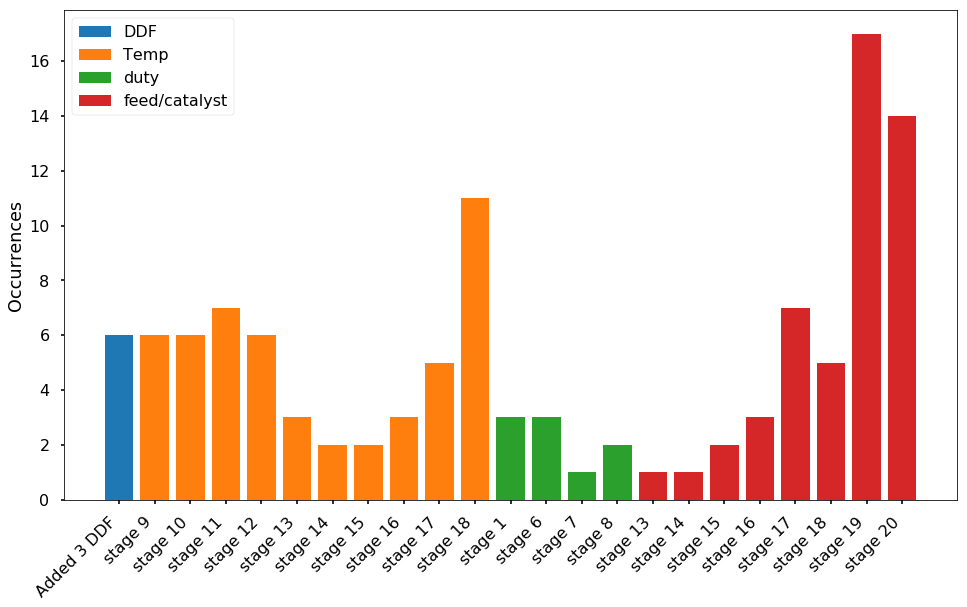

In [26]:
fig, axs = plt.subplots(figsize=(16,9))
loc = 0
names = []
for key in failure_dic.keys():
    frequencies = [j for i,j in failure_dic[key]]
    names += [i[:i.rfind(' ')] if 'DDF' not in i else i for i,j in failure_dic[key]]

    x_coordinates = np.arange(loc,len(failure_dic[key])+loc)
    axs.bar(x_coordinates, frequencies, align='center',label = key)
    loc += len(failure_dic[key])

axs.set_xticks(np.arange(loc))
axs.set_xticklabels(names,rotation=45,ha='right')

axs.set_ylabel('Occurrences')
axs.legend()
plt.show()

## Optimization Failure

In [27]:
def diff_data(x):
    x = np.array(x)
    return x[np.logical_not(finished_initialization)], \
        x[np.logical_and(np.logical_not(finished_optimization),finished_initialization)], x[finished_optimization], 

In [28]:
opt_fail_list = []

for j in range(1,total_runs[-1]+1):
    if finished_DDF[j-1] and not finished_optimization[j-1]:
        file_name = 'mul_onestep_Preset_Case:_{}_NCP.dat'.format(j)
        with open('./log/text/'+file_name) as f:
            log_content = f.readlines()
            for line in reversed(log_content):
                if line.startswith('EXIT:'):
                    if 'Optimal Solution Found' in line:
                        opt_fail_list.append('Restoration Failed')
                    else:
                        opt_fail_list.append(line.replace('EXIT: ','').replace('\n',''))
                    break

In [29]:
Counter(opt_fail_list)

Counter({'Maximum Number of Iterations Exceeded.': 85,
         'Restoration Failed': 4})

# Average processing time for solves

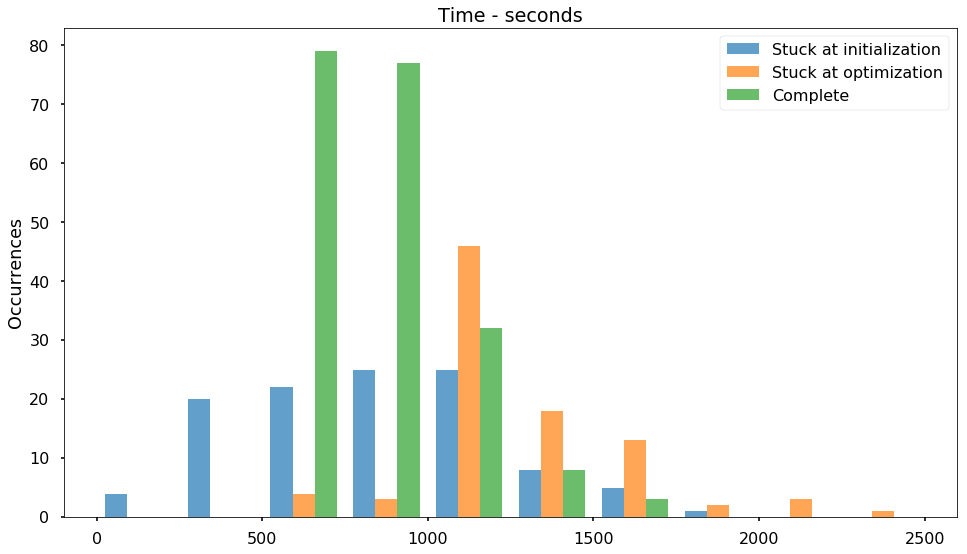

In [30]:
fig, axs = plt.subplots(figsize=(16,9))
y, bins, patches = axs.hist(diff_data(timing_list),bins=10,histtype='bar',range=(0,2500),alpha=0.7)

axs.legend(['Stuck at initialization','Stuck at optimization','Complete'])
axs.set_title('Time - seconds')
axs.set_ylabel('Occurrences')
plt.show()

# Lastly, optimization results

In [31]:
obj_list = []
opt_results = []

for j in range(1,total_runs[-1]+1):
    if finished_optimization[j-1]:
        file_name = 'mul_onestep_Preset_Case:_{}_NCP.dat'.format(j)
        with open('./log/text/'+file_name) as f:
            log_content = f.readlines()
            counter = 0
            for j, line in enumerate(reversed(log_content)):
                if line.startswith('gasoline'):
                    start = 'Wet flow  :'
                    end = 'Dry flow'
                    string = line[line.find(start)+len(start):line.rfind(end)]
                    string = string.strip()
                    obj_list.append(float(string))
                    break
            opt_results.append(log_content[-j-30:-j-29]+log_content[-j-19:-j-7]+log_content[-j-1:-j+1])
opt_results = [[data.split() for data in case] for case in opt_results]

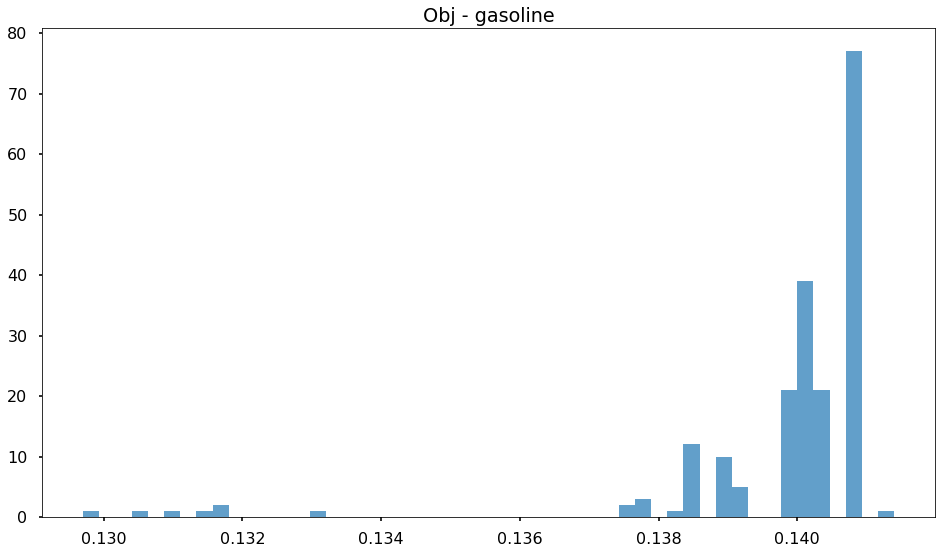

In [32]:
fig, axs = plt.subplots(figsize=(16,9))
y, bins, patches = axs.hist(obj_list,bins=50,histtype='bar',alpha=0.7)

axs.set_title('Obj - gasoline')
plt.show()

### Remove duplicates and sort

In [33]:
opt_results_matrix = np.stack((
    [float(case[0][4])/float(case[0][5]) for case in opt_results],
    [float(case[-2][-1]) for case in opt_results],
    [float(case[-2][6]) for case in opt_results],
    [float(case[-1][-1]) for case in opt_results],
    [float(case[-1][6]) for case in opt_results],
    *np.array([[float(obv[1]) for obv in case[1:13]] for case in opt_results]).T,
    *np.array([[float(obv[6]) for obv in case[1:13]] for case in opt_results]).T,
    *np.array([[float(obv[5]) for obv in case[1:13]] for case in opt_results]).T
),axis=1)

In [34]:
opt_results_unique, unique_index, unique_counts = np.unique(opt_results_matrix,axis=0,return_index=True,return_counts=True)

In [35]:
np.array(sorted([i for i in zip(opt_results_unique[:,2],unique_counts)],key=lambda x: x[0]))

array([[ 0.1297,  1.    ],
       [ 0.1305,  1.    ],
       [ 0.131 ,  1.    ],
       [ 0.1314,  1.    ],
       [ 0.1316,  2.    ],
       [ 0.1332,  1.    ],
       [ 0.1375,  2.    ],
       [ 0.1378,  3.    ],
       [ 0.1383,  1.    ],
       [ 0.1385, 12.    ],
       [ 0.1389,  5.    ],
       [ 0.1389,  5.    ],
       [ 0.1391,  4.    ],
       [ 0.1391,  1.    ],
       [ 0.1398,  5.    ],
       [ 0.1398, 15.    ],
       [ 0.1398,  1.    ],
       [ 0.1401, 39.    ],
       [ 0.1403,  5.    ],
       [ 0.1404, 16.    ],
       [ 0.1407, 77.    ],
       [ 0.1414,  1.    ]])

In [36]:
opt_results_unique = np.array(sorted(opt_results_unique,key=lambda x: x[2]))

## PCA

In [37]:
center_scaled = StandardScaler().fit_transform(opt_results_unique)
pca = PCA(n_components=10)
scores = pca.fit_transform(center_scaled)

### Eigenvalues

In [38]:
pca.explained_variance_

array([8.10584833, 7.23263015, 6.090029  , 4.1978373 , 3.6004706 ,
       2.43541121, 2.20526512, 1.95582433, 1.34480005, 0.83584589])

### Captured Covariance

In [39]:
pca.explained_variance_ratio_

array([0.20911894, 0.1865912 , 0.15711377, 0.10829801, 0.09288683,
       0.06283002, 0.05689259, 0.05045738, 0.03469386, 0.02156359])

In [40]:
sum(pca.explained_variance_ratio_[:5])

0.7540087506942589

### A strong corrolation between PC1 and optimized objective value

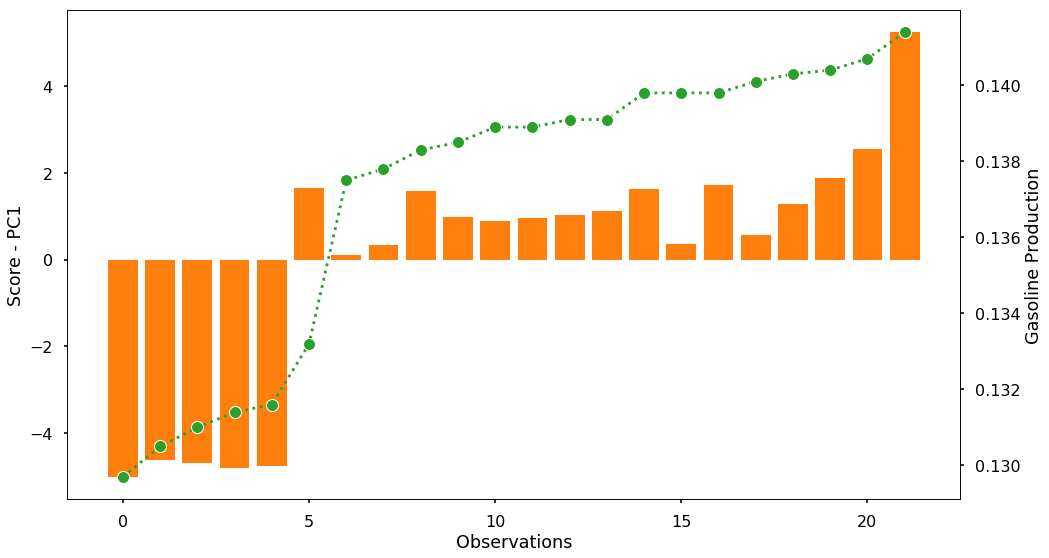

In [41]:
fig, axs = plt.subplots(figsize=(16,9))

x_loc = np.arange(len(scores[:,0]))
axs.bar(x_loc,scores[:,0],color = 'C1')

axs_ = axs.twinx()
axs_.plot(x_loc,opt_results_unique[:,2],'C2:o',markeredgecolor='w',markeredgewidth = 1,markersize=12)

# axs.legend()
axs.set_xlabel('Observations')
axs.set_ylabel('Score - PC1')
axs_.set_ylabel('Gasoline Production')

plt.show()
plt.close()

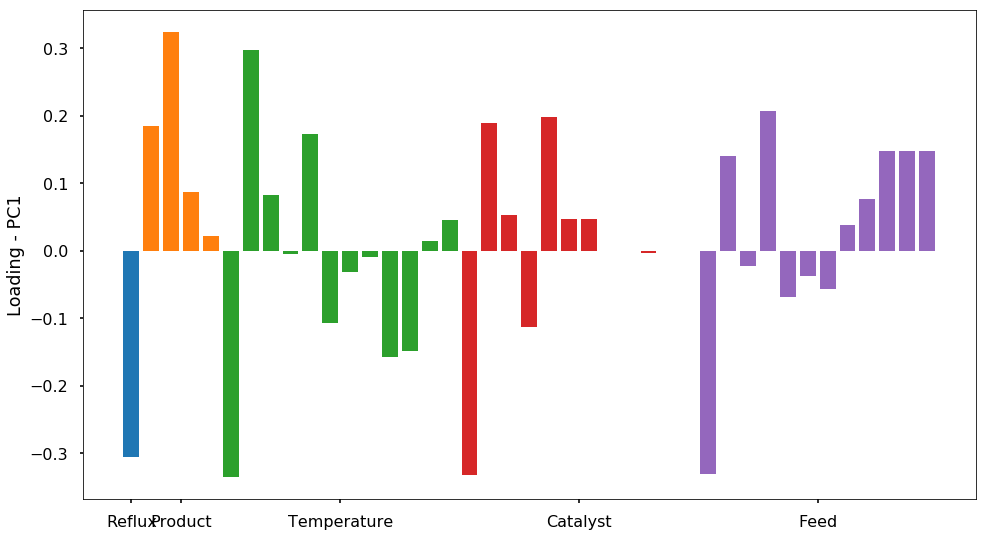

In [42]:
fig, axs = plt.subplots(figsize=(16,9))
x_loc = np.arange(1,len(pca.components_[0])+1)
grouping = {'Reflux':slice(0,1),'Product':slice(1,5),'Temperature':slice(5,17),\
            'Catalyst':slice(17,29),'Feed':slice(29,None)}

for key in grouping:
    axs.bar(x_loc[grouping[key]],pca.components_[0][grouping[key]])
axs.set_xticks([1,3.5,11.5,23.5,35.5])
axs.set_xticklabels(list(grouping.keys()))

axs.set_ylabel('Loading - PC1')
plt.show()
plt.close()

### PC2 can further explain subtle difference between high performing solutions

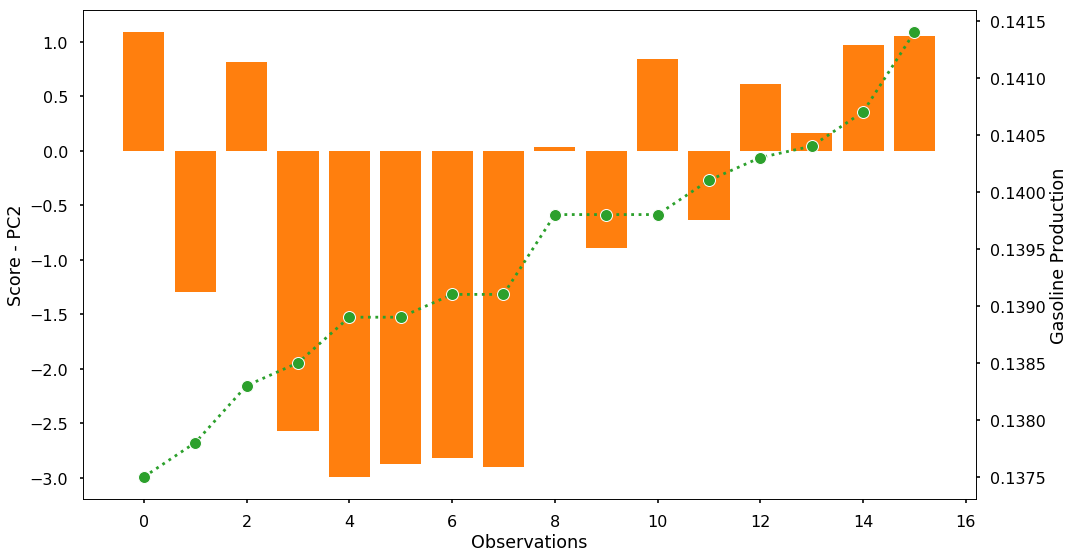

In [43]:
fig, axs = plt.subplots(figsize=(16,9))

x_loc = np.arange(len(scores[6:,1]))
axs.bar(x_loc,scores[6:,1],color = 'C1')

axs_ = axs.twinx()
axs_.plot(x_loc,opt_results_unique[6:,2],'C2:o',markeredgecolor='w',markeredgewidth = 1,markersize=12)

# axs.legend()
axs.set_xlabel('Observations')
axs.set_ylabel('Score - PC2')
axs_.set_ylabel('Gasoline Production')

plt.show()
plt.close()

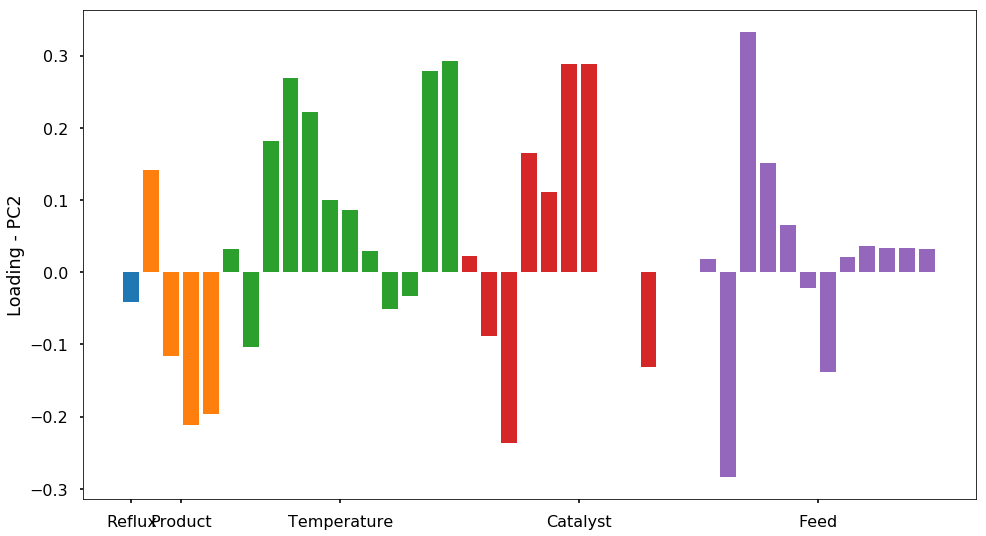

In [44]:
fig, axs = plt.subplots(figsize=(16,9))
x_loc = np.arange(1,len(pca.components_[1])+1)
grouping = {'Reflux':slice(0,1),'Product':slice(1,5),'Temperature':slice(5,17),\
            'Catalyst':slice(17,29),'Feed':slice(29,None)}

for key in grouping:
    axs.bar(x_loc[grouping[key]],pca.components_[1][grouping[key]])
axs.set_xticks([1,3.5,11.5,23.5,35.5])
axs.set_xticklabels(list(grouping.keys()))

axs.set_ylabel('Loading - PC2')
plt.show()
plt.close()

### Contributing factors

In [45]:
pd.options.display.expand_frame_repr = False
pd.options.display.max_colwidth = 80000
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [46]:
pd.options.display.precision = 0
pd.DataFrame(opt_results_unique[:,5:17].T,index=['Tem{}'.format(j) for j in range(9,21)])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
Tem9,235,237,235,235,235,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200
Tem10,200,236,200,200,200,237,238,239,238,240,240,240,240,240,238,239,239,239,239,238,238,238
Tem11,238,200,239,239,239,249,237,236,237,236,236,236,236,236,237,238,220,238,238,237,237,237
Tem12,236,200,236,236,236,237,235,200,236,200,200,200,200,200,236,234,238,234,234,236,236,236
Tem13,218,200,202,200,200,236,219,200,234,200,200,200,200,200,234,200,234,200,200,234,234,234
Tem14,300,231,226,229,230,234,300,300,227,200,226,200,227,200,224,226,205,227,228,224,224,223
Tem15,300,231,200,230,231,234,300,300,300,200,228,200,228,227,225,227,225,228,229,228,228,230
Tem16,300,200,300,200,232,235,300,300,300,300,200,300,229,228,300,200,225,229,229,228,228,231
Tem17,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,234,300,234,231
Tem18,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,230


In [47]:
pd.options.display.precision = 0
pd.DataFrame(opt_results_unique[:,17:29].T,index=['Catalyst {}'.format(j) for j in range(9,21)])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
Catalyst 9,10915,13120,10294,10434,10570,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
Catalyst 10,10,16792,10,10,10,16075,9893,12174,8856,12249,12407,12301,12489,12441,7792,9331,9504,9394,9395,7711,7715,7723
Catalyst 11,7909,10,7829,7830,7833,10,8194,17744,7638,17667,17504,17612,17413,17461,6944,7975,10,8022,8022,6897,6901,6915
Catalyst 12,11104,10,11803,11657,11509,3852,11842,10,5878,10,10,10,10,10,5723,12613,7965,12495,12511,5857,5868,6102
Catalyst 13,10,10,10,10,10,3859,10,10,7563,10,10,10,10,10,9466,10,12442,10,10,9457,9453,9198
Catalyst 14,10,10,10,10,10,5811,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
Catalyst 15,10,10,10,10,10,352,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
Catalyst 16,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
Catalyst 17,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
Catalyst 18,10,16,13,18,26,10,10,10,14,12,18,16,27,26,23,20,28,27,10,27,10,10


In [48]:
pd.options.display.precision = 2
pd.DataFrame(opt_results_unique[:,29:].T,index=['Feed {}'.format(j) for j in range(9,21)]).round(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
Feed 9,1.75,2.26,1.65,1.68,1.70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Feed 10,0.00,2.57,0.00,0.00,0.00,0.00,1.75,2.23,1.51,2.25,2.28,2.26,2.30,2.29,1.34,1.67,0.00,1.68,1.68,1.33,1.33,1.34
Feed 11,1.75,0.00,1.72,1.73,1.74,2.96,1.72,0.00,1.60,0.00,0.00,0.00,0.00,0.00,1.43,1.66,1.70,1.68,1.68,1.42,1.42,1.42
Feed 12,0.00,0.00,0.00,0.00,0.00,1.01,0.00,0.00,1.40,0.00,0.00,0.00,0.00,0.00,1.30,0.00,1.67,0.00,0.00,1.38,1.39,1.52
Feed 13,6.47,0.00,0.00,0.00,0.00,1.02,6.51,7.74,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Feed 14,0.00,0.00,6.60,0.00,0.00,0.00,0.00,0.00,5.47,7.72,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Feed 15,0.00,5.14,0.00,6.57,0.00,0.00,0.00,0.00,0.00,0.00,7.68,7.71,0.00,0.00,5.90,6.64,0.00,0.00,0.00,0.00,0.00,0.00
Feed 16,0.00,0.00,0.00,0.00,6.53,4.99,0.00,0.00,0.00,0.00,0.00,0.00,7.66,7.67,0.00,0.00,6.59,6.61,0.00,5.84,0.00,0.00
Feed 17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.62,0.00,5.84,0.00
Feed 18,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
